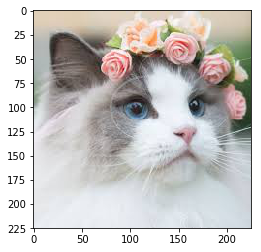

In [25]:
#圖片增廣是基於圖片數不夠的情況下，對圖片進行變形、裁剪、顏色變化等增加數量

%matplotlib inline
import matplotlib.pyplot as plt
from mxnet import image

img = image.imdecode(open('/home/wuying/Pictures/img/cat1.jpg','rb').read())
plt.imshow(img.asnumpy())

In [31]:
from mxnet import nd
import sys
sys.path.append('/home/wuying/gluon-tutorials-zh')
import utils

def apply(img,aug,n=3):
    X=[aug(img.astype('float32'))for _ in range(n*n)]#沒看懂
    # 转成float，一是因为aug需要float类型数据来方便做变化。
    # 二是这里会有一次copy操作，因为有些aug直接通过改写输入
    #（而不是新建输出）获取性能的提升
    Y=nd.stack(*X).clip(0,255)/255
    utils.show_images(Y, n, n, figsize=(8,8))

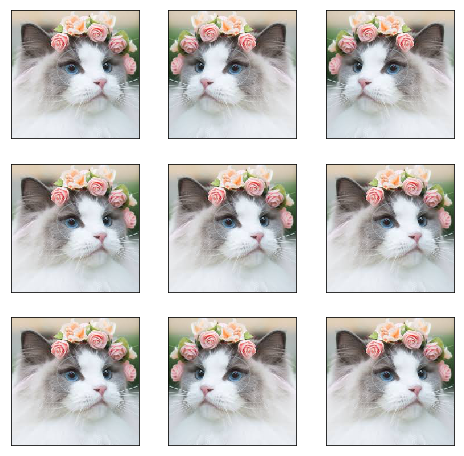

In [35]:
aug=image.HorizontalFlipAug(.5)
apply(img,aug)
#大體的格式是aug=image.做法Aug（）
#apply(img,aug)

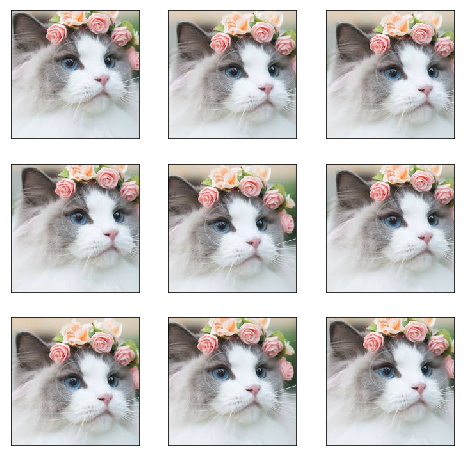

In [36]:
# 随机裁剪一个块 200 x 200 的区域 可是我沒有感覺有隨機裁剪。。。。
aug=image.RandomCropAug([200,200])
apply(img,aug)

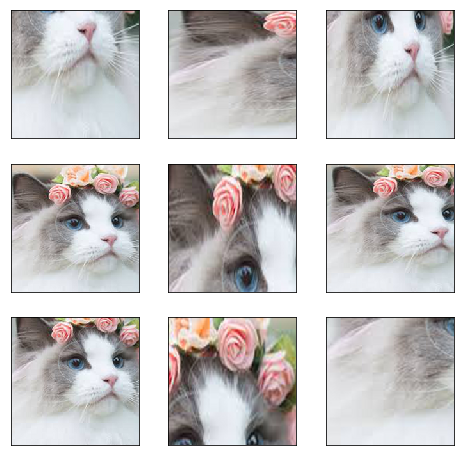

In [37]:
# 随机裁剪，要求保留至少0.1的区域，随机长宽比在.5和2之间。
# 最后将结果resize到200x200
aug=image.RandomSizedCropAug((200,200),.1,(0.5,2))
apply(img,aug)

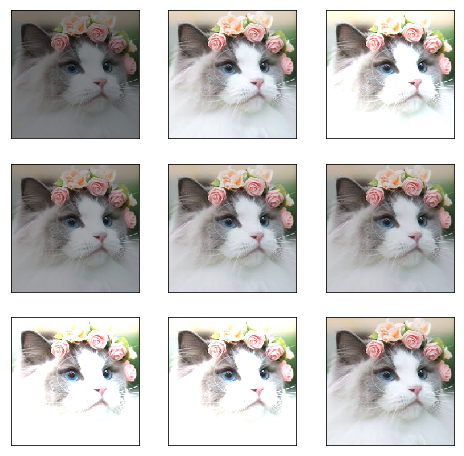

In [38]:
#顏色變化，顏色變換可以體現在亮度,色調
aug=image.BrightnessJitterAug(0.5)
apply(img,aug)

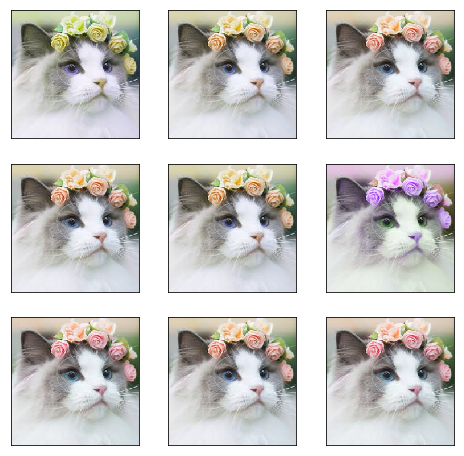

In [39]:
aug=image.HueJitterAug(0.5)
apply(img,aug)

In [40]:
#注意到图片增广通常只是针对训练数据，对于测试数据则用得较小。
#后者常用的是做5次随机剪裁，然后讲5张图片的预测结果做均值。
#首先定义一个辅助函数可以对图片按顺序应用数个增广

def apply_aug_list(img, augs):
    for f in augs:
        img = f(img)
    return img

In [42]:
train_augs=[
    image.HorizontalFlipAug(0.5),
    image.RandomCropAug([28,28])]
test_augs=[
    image.RandomCropAug([28,28])]

In [65]:
#定义数据读取
from mxnet import gluon
from mxnet import nd
import sys
sys.path.append('/home/wuying/gluon-tutorials-zh')
import utils

def get_transform(augs):
    def transform(data,label):
        data=data.astype('float32')
        if augs is not None:
            data=nd.stack(*[apply_aug_list(d,augs) for d in data])
            data=nd.transpose(data,(0,3,1,2))#不明白
        return data ,label.astype('float32')
    return transform
    
#像mnist一樣讀取數據，把讀取數據堆積在同一個包包，用def框起來

def get_data(batch_size,train_augs,test_augs=None):
    cifar10_train = gluon.data.vision.CIFAR10(
        train=True, transform=get_transform(train_augs))
    cifar10_test = gluon.data.vision.CIFAR10(
        train=False, transform=get_transform(test_augs))
    train_data = utils.DataLoader(
        cifar10_train, batch_size, shuffle=True)
    test_data = utils.DataLoader(
        cifar10_test, batch_size, shuffle=False)
    return (train_data,test_data)


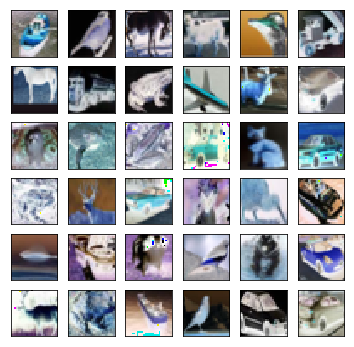

In [66]:
train_data, _ = get_data(36, train_augs)
for imgs,_ in train_data:
    break
utils.show_images(imgs.transpose((0,2,3,1)), 6, 6)

In [67]:
from mxnet import init

def train(train_augs, test_augs, learning_rate=.1):
    batch_size = 128
    num_epochs = 10
    ctx = utils.try_all_gpus()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    train_data, test_data = get_data(
        batch_size, train_augs, test_augs)
    net = utils.resnet18(10)
    net.initialize(ctx=ctx, init=init.Xavier())
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': learning_rate})
    utils.train(
        train_data, test_data, net, loss, trainer, ctx, num_epochs)

In [68]:
train(train_augs, test_augs)

Start training on  [cpu(0)]
Epoch 0. Loss: 1.475, Train acc 0.47, Test acc 0.57, Time 537.8 sec
Epoch 1. Loss: 1.054, Train acc 0.63, Test acc 0.61, Time 535.7 sec
Epoch 2. Loss: 0.867, Train acc 0.69, Test acc 0.68, Time 535.0 sec
Epoch 3. Loss: 0.763, Train acc 0.73, Test acc 0.72, Time 532.3 sec
Epoch 4. Loss: 0.683, Train acc 0.76, Test acc 0.72, Time 532.3 sec
Epoch 5. Loss: 0.627, Train acc 0.78, Test acc 0.76, Time 531.9 sec
Epoch 6. Loss: 0.576, Train acc 0.80, Test acc 0.76, Time 532.1 sec
Epoch 7. Loss: 0.539, Train acc 0.81, Test acc 0.77, Time 533.7 sec
Epoch 8. Loss: 0.511, Train acc 0.82, Test acc 0.78, Time 531.9 sec
Epoch 9. Loss: 0.476, Train acc 0.83, Test acc 0.78, Time 532.7 sec
